In [164]:
import tifffile as tiff
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

In [165]:
folder = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Panel PEGASO\Pruebas Pegatinas\doble cara 2')

filename = folder / 'aligned.tif'

output_folder = folder / 'output'

output_folder.mkdir(exist_ok=True)

data = tiff.imread(filename)
data = np.swapaxes(data, 0, 1)
data = np.swapaxes(data, 1, 2)

print(data.shape)

(164, 78, 507)


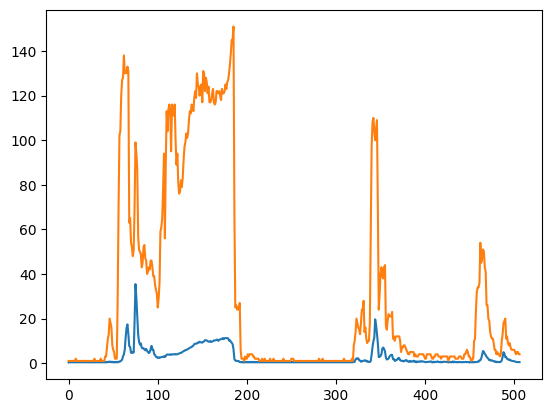

In [166]:
#Data is a 3D array of signals, where each pixel is a signal

#We can calculate the mean of the signals
mean_signal = np.mean(data,axis = (0,1))
max_signal = np.max(data,axis = (0,1))

plt.plot(mean_signal)
plt.plot(max_signal)

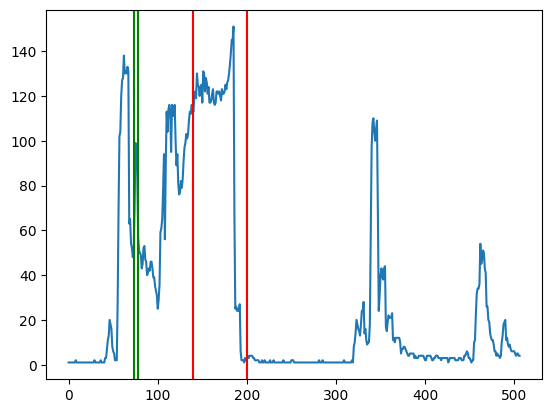

In [167]:
#gate1

gate1 = (73, 78)
gate2 = (140, 200)
gate3 = (300,data.shape[2]-1)

#plot the max_signal and a vertical line at the gates start and end, gate 1 in yellow, gate 2 in red
plt.plot(max_signal)
plt.axvline(gate1[0], color='g')
plt.axvline(gate1[1], color='g')
plt.axvline(gate2[0], color='r')
plt.axvline(gate2[1], color='r')


In [168]:
def plot_images(images, figsz = (5, 5)):
    fig, axs = plt.subplots(1, len(images), figsize=figsz)
    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

In [169]:
def circles(img):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw circles on
    circle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        # Draw the circle
        cv2.circle(circle_img, (int(x), int(y)), int(radius), (255, 255, 255), -1)

        break

    return circle_img

In [170]:
def rectangles(img, thickness=2):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw rectangles on
    rectangle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        # Draw the rectangle contour
        cv2.rectangle(rectangle_img, (x, y), (x+w, y+h), (255, 255, 255), thickness)

    return rectangle_img > 0

In [171]:
import cv2
import numpy as np

def draw_bounding_box(image):

    # Convert binary image to grayscale
    image = (image * 255).astype(np.uint8)

    # Create a new binary image of the same size
    output_image = np.zeros_like(image)

    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, draw the bounding box on the new image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(output_image, (x, y), (x+w, y+h), (255), -1)

    return output_image > 0

In [172]:
def find_rectangle_centers(image):
    # Ensure the image is binary
    assert np.array_equal(image, image.astype(bool)), "Image must be binary"

    # Find connected components in the image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image.astype('uint8'))

    # The first component is the background, so ignore it
    return centroids[1:]

In [173]:
def paint_points_on_image(points, image):
    # Create a copy of the image to avoid modifying the original
    image_copy = np.copy(image)

    # Convert the image to RGB if it's grayscale
    if len(image_copy.shape) == 2:
        image_copy = np.stack((image_copy,)*3, axis=-1)

    # Paint each point in red
    for point in points:
        x, y = point
        image_copy[int(y), int(x)] = [255, 0, 0]  # RGB for red

    return image_copy

[[28.5        37.        ]
 [46.5        54.35106383]
 [28.5        55.        ]
 [47.5        70.5       ]]


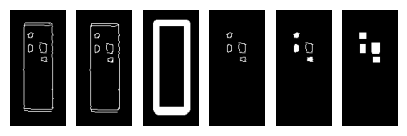

In [174]:
import cv2
from scipy import ndimage
from scipy.ndimage import label


#get the gates
gated_data = data[:,:,gate1[0]:gate1[1]]
gated_data2 = data[:,:,gate2[0]:gate2[1]]
gated_data3 = data[:,:,gate3[0]:gate3[1]]

#get the max projection of gated 1 data
max_projection = np.max(gated_data, axis=2)

#apply canny edge detection
edges = cv2.Canny(max_projection, 50, 150)

edges = edges > 0

#fill holes in edges
edges_closed = cv2.morphologyEx(edges.astype(np.uint8), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2)))

rectangle = rectangles(edges,7)

#nand the edges and the rectangle
only_circles = np.logical_and(edges, np.logical_not(rectangle))

#fill the holes in only circles using ndimage
only_circles_filled = ndimage.binary_fill_holes(only_circles)

boxes = draw_bounding_box(only_circles_filled)

centers = find_rectangle_centers(boxes)

print(centers)

plot_images([edges,edges_closed,rectangle,only_circles,only_circles_filled,boxes])

hacer local maxima con una ventana de un poco mas del tamaño de la pegatina

In [175]:
from scipy.ndimage import minimum_filter

def find_local_minima(image, size=3, threshold=50):
    # Apply the minimum filter
    filtered_image = minimum_filter(image, size)

    # Find local minima
    local_minima = image == filtered_image

    # Apply threshold
    local_minima = np.logical_and(local_minima, image <= threshold)

    # The result is a boolean mask where True indicates local minima
    return local_minima

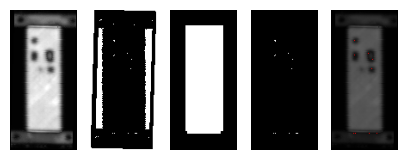

C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_8740\3514373141.py:29: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'max_projection_centers.tif', max_projection_centers)


In [176]:
#get the gates
gated_data = data[:,:,gate1[0]:gate1[1]]
gated_data2 = data[:,:,gate2[0]:gate2[1]]
gated_data3 = data[:,:,gate3[0]:gate3[1]]

#get the max projection of gated 1 data
max_projection = np.max(gated_data, axis=2)

#apply canny edge detection
edges = cv2.Canny(max_projection, 50, 150)

minimums = find_local_minima(max_projection, 10)

rectangle = rectangles(edges,1)

#fillholes in the rectangle
rectangle_fill = ndimage.binary_fill_holes(rectangle)

only_minimus = np.logical_and(minimums,rectangle_fill)

centers = find_rectangle_centers(only_minimus)

#paint the centers in the max projection
max_projection_centers = paint_points_on_image(centers, max_projection)

plot_images([max_projection, minimums,rectangle_fill, only_minimus,max_projection_centers])

#save the max projection with the centers
tiff.imsave(output_folder / 'max_projection_centers.tif', max_projection_centers)